# Playground Notebook For Quantizing VLP Models

## Initialize the Distributed Backend

In [1]:
import os
import torch.distributed as dist
import copy

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use

# Set environment variables
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

# Initialize the process group
dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

# Verify initialization
print(f"Initialized: {dist.is_initialized()}")

Initialized: True


In [2]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="promote has been superseded by promote_options='default'")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.helpers is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.layers is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.registry is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_small_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_huge_patch14_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_small_resnet26d_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet26d_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50d_224 in registry")
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")

### Define helper functions

In [3]:
import torch

def print_size_of_model(model):
    """
    Function to print the size of the model.

    Args:
        model (torch.nn.Module): The model to get the size
    
    Returns:
        None
    """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def get_accuracy(pl_module, logits, target, device="cpu"):
        correct = 0
        total = 0
        logits, target = (
            logits.detach().to(device),
            target.detach().to(device),
        )
        preds = logits.argmax(dim=-1)
        preds = preds[target != -100]
        target = target[target != -100]
        if target.numel() == 0:
            return 1

        assert preds.shape == target.shape

        correct += torch.sum(preds == target)
        total += target.numel()

        return correct/total

### Define the Configuration to Initialize the Datamodule and Model

In [4]:
import pytorch_lightning as pl
import configs

# Set the configuration
_config = configs.vilt_config_nlvr2
_config["batch_size"] = 32


pl.seed_everything(_config["seed"])

/data-4/users/mileriso/envs/.dev/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
Seed set to 0


0

## Initialize the Datamodule

Create a child datamodule that constructs a smaller version of the full datamodule

In [5]:
from torch.utils.data import Subset
from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
from meter.datamodules.multitask_datamodule import MTDataModule as MTDataModuleMeter

class SmallMTDataModuleVILT(MTDataModuleVILT):
    def __init__(self, _config, dist=False, num_samples=5, start_idx=100):
        super().__init__(_config, dist)
        self.num_samples = num_samples
        self.start_idx = start_idx

    def setup(self, stage):
        super().setup(stage)
        
        # Limit the number of samples in the datasets
        self.train_dataset = Subset(self.train_dataset, range(self.start_idx, self.start_idx+self.num_samples))
        self.val_dataset = Subset(self.val_dataset, range(self.start_idx, self.start_idx+self.num_samples))
        self.test_dataset = Subset(self.test_dataset, range(self.start_idx, self.start_idx+self.num_samples))

class SmallMTDataModuleMETER(MTDataModuleMeter):
    def __init__(self, _config, dist=False, num_samples=10, start_idx=100):
        super().__init__(_config, dist)
        self.num_samples = num_samples
        self.start_idx = start_idx

    def setup(self, stage):
        super().setup(stage)
        
        # Limit the number of samples in the datasets
        self.train_dataset = Subset(self.train_dataset, range(self.start_idx, self.start_idx+self.num_samples))
        self.val_dataset = Subset(self.val_dataset, range(self.start_idx, self.start_idx+self.num_samples))
        self.test_dataset = Subset(self.test_dataset, range(self.start_idx, self.start_idx+self.num_samples))

2025-01-10 06:10:29.235887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736485829.253185 2955685 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736485829.258449 2955685 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Select the configuration and initialize the test and full datamodule

In [6]:
# ==========================================
# ========= Create full datamodule =========
# ==========================================
if "meter" in _config["model"]:
    full_dm = MTDataModuleMeter(_config, dist=False)
    
    calibrarte_dm = SmallMTDataModuleMETER(_config, dist=False, num_samples=5, start_idx=100)
    
    infer_dm = SmallMTDataModuleMETER(_config, dist=False, num_samples=5, start_idx=0)
    infer_dm.setup("test")
    infer_dataloader = infer_dm.test_dataloader()

elif "vilt" in _config["model"]:
    full_dm = MTDataModuleVILT(_config, dist=False)

    calibrarte_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=5, start_idx=100)
    
    infer_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=5, start_idx=0)
    infer_dm.setup("test")
    infer_dataloader = infer_dm.test_dataloader()

else:
    raise ValueError("Model not supported: ", _config["model"])


Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']


## Initialize The Model

In [7]:
from vilt.modules import ViLTransformerSS
from meter.modules import METERTransformerSS

if _config["model"] == "vilt":
    model = ViLTransformerSS(_config)
    print("Initialized ViLT model")

elif _config["model"] == "meter":
    model = METERTransformerSS(_config)
    print("Initialized METER model")

else:
    raise ValueError("Model not supported: ", _config["model"])

Initialized ViLT model


## Initialize The Trainer

In [8]:
# ========== Initialize the trainer for full precision ==========
exp_name = f'{_config["exp_name"]}'

os.makedirs(_config["log_dir"], exist_ok=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    verbose=True,
    monitor="val/the_metric",
    mode="max",
    save_last=True,
)
logger = pl.loggers.TensorBoardLogger(
    _config["log_dir"],
    name=f'{exp_name}_seed{_config["seed"]}_from_{_config["load_path"].split("/")[-1][:-5]}',
)

lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="step")
callbacks = [checkpoint_callback, lr_callback]

num_gpus = (
    _config["num_gpus"]
    if isinstance(_config["num_gpus"], int)
    else len(_config["num_gpus"])
)

grad_steps = _config["batch_size"] // (
    _config["per_gpu_batchsize"] * num_gpus * _config["num_nodes"]
)

max_steps = _config["max_steps"] if _config["max_steps"] is not None else None


trainer = pl.Trainer(
        accelerator="cpu",
        devices=1,
        num_nodes=_config["num_nodes"],
        precision=_config["precision"],
        # strategy="ddp",
        benchmark=True,
        deterministic=False,
        max_epochs=_config["max_epoch"] if max_steps is None else 1000,
        max_steps=max_steps,
        callbacks=callbacks,
        logger=logger,
        # accumulate_grad_batches=grad_steps,
        log_every_n_steps=10,
        fast_dev_run=_config["fast_dev_run"],
        val_check_interval=_config["val_check_interval"],
    )

# trainer.test(model, datamodule=calibrarte_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data-4/users/mileriso/envs/.dev/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


# Quantization | PTQ to 8-bits

In [9]:
# model_static = copy.deepcopy(model)

# quantization_config = torch.quantization.QConfig(
#             activation=torch.quantization.HistogramObserver.with_args(
#                                                 dtype=torch.quint8,
#                                                 quant_min=0,
#                                                 quant_max=255,
#                                                 reduce_range=False,
#                                             ),
#             weight=torch.quantization.MinMaxObserver.with_args(
#                                             dtype=torch.qint8,
#                                             qscheme=torch.per_tensor_symmetric,
#                                             quant_min=-128,
#                                             quant_max=127,
#                                         ),
#     )

# embedding_qconfig = torch.quantization.QConfig(
#     activation=torch.quantization.HistogramObserver.with_args(
#                                             dtype=torch.quint8,
#                                             quant_min=0,
#                                             quant_max=255,
#                                             reduce_range=False,
#                                         ),
#     weight=torch.quantization.PerChannelMinMaxObserver.with_args(
#                                         dtype=torch.quint8,
#                                         qscheme=torch.per_channel_affine_float_qparams,
#                                         ch_axis=0,
#                                         quant_min=0,
#                                         quant_max=255,
#                                     ),
#     )

# # Assign the quantization configurations to the model
# # model_static.vit_model.visual.transformer.qconfig = quantization_config
# model_static.vit_model.visual.transformer.resblocks[0].attn.qconfig = quantization_config
# model_static.vit_model.visual.transformer.resblocks[0].attn.qconfig = quantization_config
# model_static.vit_model.visual.transformer.resblocks[0].attn.qconfig = quantization_config
# model_static.vit_model.visual.transformer.resblocks[0].attn.qconfig = quantization_config

# # Perform static quantization
# torch.quantization.prepare(model_static, inplace=True)
# trainer.test(model_static, datamodule=calibrarte_dm)
# torch.quantization.convert(model_static, inplace=True)

# print("Size after quantization:")
# print_size_of_model(model_static)

# trainer.test(model_static, datamodule=calibrarte_dm)

In [10]:
# print(model_static)

### Dynamic Quantization

In [11]:
import torch
from torch.quantization import PlaceholderObserver, MinMaxObserver, QConfig, PerChannelMinMaxObserver
from sensitivity_utils import init_trainer, get_quantization_config, print_size_of_model
import copy

bit8_linear, bit8_embedding = get_quantization_config(8)
bit4_linear, bit4_embedding = get_quantization_config(4)
bit2_linear, bit2_embedding = get_quantization_config(2)
bit1_linear, bit1_embedding = get_quantization_config(1)


print("Full Precision Model:")
print_size_of_model(model)

model_8 = copy.deepcopy(model)
model_4 = copy.deepcopy(model)
model_2 = copy.deepcopy(model)
model_1 = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Embedding: bit8_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Linear: bit8_linear, torch.nn.LayerNorm: bit8_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Embedding: bit4_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Linear: bit4_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Embedding: bit2_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Linear: bit2_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Embedding: bit1_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Linear: bit1_linear, torch.nn.LayerNorm: bit1_linear}, dtype=torch.qint8, inplace=True
)



print("Fully Quantized Model:")
print_size_of_model(model_8)

# print(f"Quantized Model with only the {layer_to_quantize} layer:")
# print_size_of_model(_model_)

Full Precision Model:
Size of the model (MB): 455.900978
Fully Quantized Model:
Size of the model (MB): 122.099212


In [40]:
import torch

# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'

with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize()  # Dequantize 8-bit weights
    weight_4bit = block_4bit.weight().dequantize()  # Dequantize 4-bit weights
    weight_2bit = block_2bit.weight().dequantize()  # Dequantize 2-bit weights

    # Compute relative changes
    relative_change_8bit = torch.abs(weight_full_precision - weight_8bit) / torch.abs(weight_full_precision)
    relative_change_4bit = torch.abs(weight_full_precision - weight_4bit) / torch.abs(weight_full_precision)
    relative_change_2bit = torch.abs(weight_full_precision - weight_2bit) / torch.abs(weight_full_precision)

    # Handle division by zero (if any original weight is zero)
    relative_change_8bit[torch.isnan(relative_change_8bit)] = 0  # Set NaN to 0
    relative_change_4bit[torch.isnan(relative_change_4bit)] = 0  # Set NaN to 0
    relative_change_2bit[torch.isnan(relative_change_2bit)] = 0  # Set NaN to 0

    # Convert to percentage (optional)
    relative_change_8bit_percent = relative_change_8bit * 100
    relative_change_4bit_percent = relative_change_4bit * 100
    relative_change_2bit_percent = relative_change_2bit * 100

    # Print statistics
    print("8-bit Relative Change (Mean):", torch.mean(relative_change_8bit).item())
    print("4-bit Relative Change (Mean):", torch.mean(relative_change_4bit).item())
    print("2-bit Relative Change (Mean):", torch.mean(relative_change_2bit).item())

    print("8-bit Relative Change (Max):", torch.max(relative_change_8bit).item())
    print("4-bit Relative Change (Max):", torch.max(relative_change_4bit).item())
    print("2-bit Relative Change (Max):", torch.max(relative_change_2bit).item())

    print("8-bit Relative Change Percentage (Mean):", torch.mean(relative_change_8bit_percent).item())
    print("4-bit Relative Change Percentage (Mean):", torch.mean(relative_change_4bit_percent).item())
    print("2-bit Relative Change Percentage (Mean):", torch.mean(relative_change_2bit_percent).item())

    # Identify weights with the largest relative changes
    top_k = 10  # Number of top weights to identify
    top_8bit_indices = torch.topk(relative_change_8bit.flatten(), k=top_k).indices
    top_4bit_indices = torch.topk(relative_change_4bit.flatten(), k=top_k).indices
    top_2bit_indices = torch.topk(relative_change_2bit.flatten(), k=top_k).indices

    print("Top 8-bit weights with largest relative changes:", top_8bit_indices)
    print("Top 4-bit weights with largest relative changes:", top_4bit_indices)
    print("Top 2-bit weights with largest relative changes:", top_2bit_indices)

8-bit Relative Change (Mean): 0.1676570475101471
4-bit Relative Change (Mean): 0.925999104976654
2-bit Relative Change (Mean): 0.9999205470085144
8-bit Relative Change (Max): 1.0
4-bit Relative Change (Max): 1.0
2-bit Relative Change (Max): 1.0
8-bit Relative Change Percentage (Mean): 16.765705108642578
4-bit Relative Change Percentage (Mean): 92.59990692138672
2-bit Relative Change Percentage (Mean): 99.9920425415039
Top 8-bit weights with largest relative changes: tensor([ 78,  44,  72,  38,  15, 132, 155, 172, 144,  64])
Top 4-bit weights with largest relative changes: tensor([ 8,  9,  4,  3,  5,  1,  0, 10,  2,  6])
Top 2-bit weights with largest relative changes: tensor([8, 9, 4, 7, 5, 3, 1, 0, 2, 6])


In [12]:

# Function to get the block from the model
def get_block(model, block_selection):
    attrs = block_selection.split('.')
    block = model
    for attr in attrs:
        if '[' in attr and ']' in attr:
            attr_name, index = attr[:-1].split('[')
            block = getattr(block, attr_name)[int(index)]
        else:
            block = getattr(block, attr)
    return block



In [30]:
# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'
with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize() # .int_repr().float()
    weight_4bit = block_4bit.weight().dequantize() # .int_repr().float()
    weight_2bit = block_2bit.weight().dequantize() # .int_repr().float()

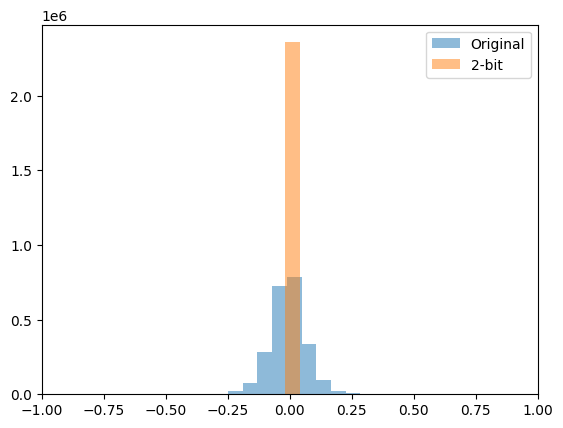

KL Divergence: 0.006750397456343222
KL Divergence: 17.704822635573848
KL Divergence: 24.204427696510965


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Example: Plot histograms
plt.hist(weight_full_precision.flatten().detach().numpy(), bins=50, alpha=0.5, label="Original")
# plt.hist(weight_8bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="8-bit")
# plt.hist(weight_4bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="4-bit")
plt.hist(weight_2bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="2-bit")
plt.legend()
plt.xlim(-1, 1)
plt.show()

def compute_kl_divergence(original, quantized, bins=50, epsilon=1e-10):
    hist_original, _ = np.histogram(original, bins=bins, density=True)
    hist_quantized, _ = np.histogram(quantized, bins=bins, density=True)
    
    # Add epsilon to avoid zero probabilities
    hist_original = hist_original + epsilon
    hist_quantized = hist_quantized + epsilon
    
    # Normalize to ensure valid probability distributions
    hist_original = hist_original / np.sum(hist_original)
    hist_quantized = hist_quantized / np.sum(hist_quantized)
    
    return entropy(hist_original, hist_quantized)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_8bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_4bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_2bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

In [16]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_full_precision.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_full_precision.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_full_precision.mean().item())

Max value of the first layer of the transformer blocks:
2.4307639598846436

Min value of the first layer of the transformer blocks:
-3.06199312210083

Average of the first layer of the transformer blocks:
3.992090205429122e-05


In [22]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_8bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_8bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_8bit.mean().item())
print()

print(f"Average difference between 8-bit version and full precision:")
print(torch.abs(block_8bit.weight().dequantize() - weight_full_precision).mean().item())

Max value of the first layer of the transformer blocks:
2.4255788326263428

Min value of the first layer of the transformer blocks:
-3.074000835418701

Average of the first layer of the transformer blocks:
3.338760870974511e-05

Average difference between 8-bit version and full precision:
0.005997746717184782


In [21]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_4bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_4bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_4bit.mean().item())
print()

print(f"Average difference between 4-bit version and full precision:")
print(torch.abs(weight_4bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 4-bit version and 8-bit version:")
print(torch.abs(weight_4bit - weight_8bit).mean().item())

Max value of the first layer of the transformer blocks:
2.449594497680664

Min value of the first layer of the transformer blocks:
-3.2661259174346924

Average of the first layer of the transformer blocks:
1.4881919923936948e-05

Average difference between 4-bit version and full precision:
0.04256489500403404

Average difference between 4-bit version and 8-bit version:
0.042156487703323364


In [20]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_2bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_2bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_2bit.mean().item())
print()

print(f"Average difference between 2-bit version and full precision:")
print(torch.abs(weight_2bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 2-bit version and 8-bit version:")
print(torch.abs(weight_2bit - weight_8bit).mean().item())
print()

print(f"Average difference between 2-bit version and 4-bit version:")
print(torch.abs(weight_2bit - weight_4bit).mean().item())

Max value of the first layer of the transformer blocks:
2.0413286685943604

Min value of the first layer of the transformer blocks:
-4.082657337188721

Average of the first layer of the transformer blocks:
-1.7304555512964725e-06

Average difference between 2-bit version and full precision:
0.0428580567240715

Average difference between 2-bit version and 8-bit version:
0.042456429451704025

Average difference between 2-bit version and 4-bit version:
0.001149368821643293


In [18]:
# Print the submodules of the model
print("Model submodules")
names, modules = zip(*list(model.named_modules()))
print(names)

Model submodules
('', 'cross_modal_text_transform', 'cross_modal_image_transform', 'token_type_embeddings', 'vit_model', 'vit_model.visual', 'vit_model.visual.conv1', 'vit_model.visual.ln_pre', 'vit_model.visual.transformer', 'vit_model.visual.transformer.resblocks', 'vit_model.visual.transformer.resblocks.0', 'vit_model.visual.transformer.resblocks.0.attn', 'vit_model.visual.transformer.resblocks.0.attn.out_proj', 'vit_model.visual.transformer.resblocks.0.ln_1', 'vit_model.visual.transformer.resblocks.0.mlp', 'vit_model.visual.transformer.resblocks.0.mlp.c_fc', 'vit_model.visual.transformer.resblocks.0.mlp.gelu', 'vit_model.visual.transformer.resblocks.0.mlp.c_proj', 'vit_model.visual.transformer.resblocks.0.ln_2', 'vit_model.visual.transformer.resblocks.1', 'vit_model.visual.transformer.resblocks.1.attn', 'vit_model.visual.transformer.resblocks.1.attn.out_proj', 'vit_model.visual.transformer.resblocks.1.ln_1', 'vit_model.visual.transformer.resblocks.1.mlp', 'vit_model.visual.transfor

In [24]:
import dynamic_quantization as dq

default_dynamic = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Embedding, torch.nn.Conv2d}, dtype=torch.quint8, inplace=True
    )

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Linear, torch.nn.LayerNorm, torch.nn.Conv2d}, dtype=torch.qint8, inplace=True
    )

print("Size after quantization:")
print_size_of_model(default_dynamic)
print(default_dynamic)

Size after quantization:
Size (MB): 122.099212
ViLTransformerSS(
  (text_embeddings): BertEmbeddings(
    (word_embeddings): QuantizedEmbedding(num_embeddings=30522, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (position_embeddings): QuantizedEmbedding(num_embeddings=40, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (quant): QuantStub()
    (dequant): DeQuantStub()
  )
  (token_type_embeddings): QuantizedEmbedding(num_embeddings=3, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32),

In [72]:
import dynamic_quantization as dq

custom_8bit = copy.deepcopy(model)
custom_8bit = dq.quantize_model_dynamic(custom_8bit, 8)

print("Size after quantization:")
print_size_of_model(custom_8bit)
# print(model_dynamic)

======== Quantizing the model DYNAMIC =========
Size after quantization:
Size of the model (MB): 122.099212


# Numeric Suite Analysis

In [73]:
import torch.quantization._numeric_suite as ns

def compute_error(x, y):
    """
    Signal to Noise Ratio (SNR)    
    """
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

## Dynamic Model

In [74]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), custom_8bit.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [81]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [82]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(custom_8bit), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [83]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.60
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.39
5 - transformer.blocks.0.attn.proj.stats
5 - -2.19
6 - transformer.blocks.0.norm2.stats
6 - -1.20
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.85
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.46
9 - transformer.blocks.1.norm1.stats
9 - -1.73
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.21
11 - transformer.blocks.1.attn.proj.stats
11 - -1.97
12 - transformer.blocks.1.norm2.stats
12 - -0.67
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.16
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.57
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.13
17 - transformer.blocks.2.attn.proj.stats
17 - -2.05
18 - transformer.blocks.2.norm2.stats
18 - -0.66
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.54
20 - transformer.bloc

# 8-bit

In [84]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_8.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [85]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_8), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [88]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.87
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.13
5 - transformer.blocks.0.attn.proj.stats
5 - -2.44
6 - transformer.blocks.0.norm2.stats
6 - -1.42
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.71
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.41
9 - transformer.blocks.1.norm1.stats
9 - -1.86
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.06
11 - transformer.blocks.1.attn.proj.stats
11 - -2.14
12 - transformer.blocks.1.norm2.stats
12 - -0.78
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.07
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.65
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.03
17 - transformer.blocks.2.attn.proj.stats
17 - -2.07
18 - transformer.blocks.2.norm2.stats
18 - -0.73
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.47
20 - transformer.bloc

## 4-bit Model

In [89]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_4.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 4.57
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.87
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 3.18
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 7.66
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 4.76
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 3.51
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.10
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 9.37
16 - trans

In [90]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [91]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_4), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [92]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 14.32
1 - text_embeddings.quant.stats
1 - 14.07
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.89
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.17
5 - transformer.blocks.0.attn.proj.stats
5 - -0.62
6 - transformer.blocks.0.norm2.stats
6 - -1.70
7 - transformer.blocks.0.mlp.fc1.stats
7 - 2.84
8 - transformer.blocks.0.mlp.fc2.stats
8 - -0.42
9 - transformer.blocks.1.norm1.stats
9 - -2.18
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.19
11 - transformer.blocks.1.attn.proj.stats
11 - -3.70
12 - transformer.blocks.1.norm2.stats
12 - -1.32
13 - transformer.blocks.1.mlp.fc1.stats
13 - 2.90
14 - transformer.blocks.1.mlp.fc2.stats
14 - -0.18
15 - transformer.blocks.2.norm1.stats
15 - -2.15
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.48
17 - transformer.blocks.2.attn.proj.stats
17 - -1.89
18 - transformer.blocks.2.norm2.stats
18 - -1.27
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.55
20 - transformer.bloc

## 2-bit

In [93]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_2.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.39
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.07
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.04
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.03
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.32
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.03
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.04
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.03
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.27
16 - trans

In [94]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_2), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [95]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 3.22
1 - text_embeddings.quant.stats
1 - -0.85
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.04
4 - transformer.blocks.0.attn.qkv.stats
4 - 4.84
5 - transformer.blocks.0.attn.proj.stats
5 - 0.19
6 - transformer.blocks.0.norm2.stats
6 - -1.89
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.47
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.06
9 - transformer.blocks.1.norm1.stats
9 - -2.27
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.57
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.63
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.43
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.29
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.54
17 - transformer.blocks.2.attn.proj.stats
17 - -0.06
18 - transformer.blocks.2.norm2.stats
18 - -1.64
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.72
20 - transformer.blocks.2.

## 1-bit

In [96]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_1.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.00
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.00
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.00
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.00
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.00
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.00
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.00
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.00
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.00
16 - trans

In [97]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_1), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [98]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 2.06
1 - text_embeddings.quant.stats
1 - -12.40
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.05
4 - transformer.blocks.0.attn.qkv.stats
4 - 5.05
5 - transformer.blocks.0.attn.proj.stats
5 - 0.34
6 - transformer.blocks.0.norm2.stats
6 - -1.95
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.40
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.03
9 - transformer.blocks.1.norm1.stats
9 - -2.34
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.93
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.64
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.30
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.38
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.82
17 - transformer.blocks.2.attn.proj.stats
17 - 0.04
18 - transformer.blocks.2.norm2.stats
18 - -1.67
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.29
20 - transformer.blocks.2.